### 보스턴 주택 가격 데이터셋

In [1]:
from keras.datasets import boston_housing

(train_data, train_targets),(test_data, test_targets) = \
boston_housing.load_data()

65536/57026 [==================================] - 0s 0us/step


In [2]:
print('훈련 데이터의 크기 : ', train_data.shape)
print('테스트 데이터의 크기 : ', test_data.shape)

훈련 데이터의 크기 :  (404, 13)
테스트 데이터의 크기 :  (102, 13)


### 데이터 준비

In [3]:
mean = train_data.mean(axis=0)
std = train_data.std(axis=0)

train_data -= mean 
train_data /= std

test_data -= mean
test_data /= std

### 모델 구성

In [4]:
from keras.models import Sequential
from keras.layers import Dense

def build_model():
  model = Sequential()
  model.add(Dense(64, activation='relu', 
                  input_dim=train_data.shape[1]))
  model.add(Dense(64, activation='relu'))
  model.add(Dense(1))
  model.compile(optimizer='rmsprop', 
                loss='mse', 
                metrics=['mae'])
  return model

### K-겹 검증을 사용한 훈련 검증

In [5]:
import numpy as np

k = 4
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []
for i in range(k):
    print('처리중인 폴드 #', i)
    # 검증 데이터 준비: k번째 분할
    val_data = \
    train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = \
    train_targets[i * num_val_samples: (i + 1) * num_val_samples]

    # 훈련 데이터 준비: 다른 분할 전체
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)

    # 케라스 모델 구성(컴파일 포함)
    model = build_model()
    # 모델 훈련(verbose=0 이므로 훈련 과정이 출력되지 않습니다)
    model.fit(partial_train_data, partial_train_targets,
              epochs=num_epochs, batch_size=1, verbose=0)
    # 검증 세트로 모델 평가
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)

처리중인 폴드 # 0
처리중인 폴드 # 1
처리중인 폴드 # 2
처리중인 폴드 # 3


In [6]:
all_scores

[1.9699649810791016,
 2.9172611236572266,
 2.8498713970184326,
 2.4854683876037598]

In [7]:
np.mean(all_scores)

2.55564147233963

In [8]:
from keras import backend as K

# 메모리 해제
K.clear_session()

In [9]:
num_epochs = 300
all_mae_histories = []
for i in range(k):
    print('처리중인 폴드 #', i)
    # 검증 데이터 준비: k번째 분할
    val_data = \
    train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = \
    train_targets[i * num_val_samples: (i + 1) * num_val_samples]

    # 훈련 데이터 준비: 다른 분할 전체
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)

    # 케라스 모델 구성(컴파일 포함)
    model = build_model()
    # 모델 훈련(verbose=0 이므로 훈련 과정이 출력되지 않습니다)
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=1, verbose=0)
    mae_history = history.history['val_mae']
    all_mae_histories.append(mae_history)

처리중인 폴드 # 0
처리중인 폴드 # 1
처리중인 폴드 # 2
처리중인 폴드 # 3


In [10]:
average_mae_history = [
    np.mean([x[i] for x in all_mae_histories]) 
                  for i in range(num_epochs)]

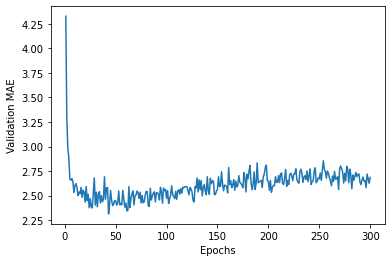

In [11]:
import matplotlib.pyplot as plt

plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()